In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# calcul de Phi(X)

def Phi(X,phi_j,J):
    Phi_X = [[0]*J*len(X[0]) for _ in range(len(X))]

    for i in range(len(X)):
        pointeur = 0
        for parametre in range(len(X[0])):
            for j in range(J):
                Phi_X[i][pointeur] = phi_j(j,X[i][parametre])
                pointeur += 1
    return Phi_X

# dans le cas des B-splines, on veut des courbes de même degré décalées pour remplir l'intervalle pris par les X

def partie_positive(n,x):
    if x < 0:
        return 0
    elif x == 0 and n == 0:
        return 0.5
    elif x > 0 and n == 0:
        return 1
    elif x >= 0 and n>= 1:
        return x**n

def b_spline(n,x):
    somme = 0
    for k in range(n+2):
        somme += (-1)**k * (n+1)/(math.factorial(n+1-k)*math.factorial(k)) * partie_positive(n,x-k+(n+1)/2)

    return somme

def testCourbes(nbPoints,a,b,nbCourbes):
    abscisses = [a+k*(b-a)/nbPoints for k in range(nbPoints)]
    for k in range(nbCourbes):
        ordonnees = []
        for x in abscisses:
            ordonnees.append(b_spline(k,x))
        plt.plot(abscisses,ordonnees)
    plt.show()

# Fourier

def fourier(n,x):
    if n%2 == 0:
        return np.cos((n//2)*x)/np.sqrt(2*np.pi)
    else:
        return np.sin((n-1)//2*x)/np.sqrt(2*np.pi)

def polynomial(n,x):
    return x**n

In [3]:
def extraction_estimateur(Y,F,phi_j,X,J,K,d,T,p):
    
    def trier_couples_propres(l):
        intermediaire = []
        for i in range(len(l)):
            intermediaire.append([l[i][0],i])
        intermediaire.sort()
        nouv_couples_propres = []
        for i in range(len(l)):
            indice = intermediaire[i][1]
            nouv_couples_propres.append(l[indice])
        return nouv_couples_propres
    
    Phi_X = Phi(X,phi_j,J)
    epsilon = 0.00001
    correctif = np.multiply(epsilon,np.identity(len(Phi_X[0]),dtype=float))
    Phi_t_Phi = np.add(correctif,np.dot(np.transpose(Phi_X),Phi_X))
    #Phi_t_Phi = np.dot(np.transpose(Phi_X),Phi_X)
    inv_Phi_t_Phi = np.linalg.inv(Phi_t_Phi)
    P = np.dot(np.dot(Phi_X,inv_Phi_t_Phi),np.transpose(Phi_X))
    PY = np.dot(P,Y)
    YtPY = np.dot(np.transpose(Y),PY)
    
    val_propres, vect_propres = np.linalg.eigh(YtPY)
    vect_propres = vect_propres.T
    couples_propres = []
    for i in range(T):
        couples_propres.append([val_propres[i],vect_propres[i]])
    couples_propres = trier_couples_propres(couples_propres)
    np.flip(couples_propres)
    
    arg_max = 0
    rapport_max = couples_propres[0][0]/couples_propres[1][0]
    for k in range(T-1):
       if couples_propres[k][0]/couples_propres[k+1][0] > rapport_max:
           arg_max = k
           rapport_max = couples_propres[k][0]/couples_propres[k+1][0]
    K_chap = arg_max
    
    print(K_chap)
    # K_chap = T//2
    
    F_chap = [[0]*K_chap for _ in range(T)]
    for i in range(K_chap):
        for j in range(T):
            F_chap[j][i] = np.sqrt(T)*couples_propres[i][1][j]

    F_chap = np.asarray(F_chap)
    print(F_chap.T @ F_chap / T)
            
    G_X_chap = np.multiply(1/T,np.dot(PY,F_chap))
    Lambda_chap = np.multiply(1/T,np.dot(Y,F_chap))
    Gamma_chap = np.subtract(Lambda_chap,G_X_chap)
    B_chap = np.dot(np.dot(inv_Phi_t_Phi,np.transpose(Phi_X)),Lambda_chap)

    return B_chap, K_chap, F_chap, Gamma_chap

In [4]:
def traitement(intervalle_entrainement):
    # reçoit les intervalles de données de X-Alpha, de la forme

    # les intervalles de temps sont inclus dans [0,24]
    info = pd.read_csv('./data/info_charact.csv', index_col = 0)
    char_names = info.iloc[:, 0]
    file_names = np.array([str(x) + '.csv' for x in info.index.values])
    d = len(info)-1
    
    def get_data(start_date: int = 0, final_date: int = 24, shape: str = '') -> tuple[pd.DataFrame, pd.DataFrame] :
        
        entreprises_considerees = 180
        
        parse = lambda  x : pd.read_csv(f'./data/{x}', index_col = 0, parse_dates = True)

        # filter NaN values
        data_list = [parse(file).iloc[start_date:final_date+1,:] for file in file_names if file != '44.csv']
        asset_names = set.intersection(*[set(df.dropna(axis=1).columns.values) for df in data_list])
        
        # get features
        
        F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
        F_train.columns = list(char_names[:-1])
        
        # get input data
        X_train = pd.DataFrame(data=[df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=0) for df in data_list], index=list(char_names[:-1])).T
        
        # get returns [range]
        Y = parse('44.csv')[asset_names].T
        Y_train = Y.iloc[0:entreprises_considerees,intervalle_entrainement[0]:intervalle_entrainement[1]+1] 
        
        # choice of shapes'
        # normalize (column ~ [0 mean, 1 std])
        if shape == 'norm':
            norm  = lambda x : (x-x.mean())/x.std()
            X_train = norm(X_train)
            Y_train = norm(Y_train)

        # scale (column ~ [0,1] range)
        elif shape == 'scale':
            scale = lambda x : (x-x.min())/(x.max()-x.min())
            X_train = scale(X_train)
            Y_train = scale(Y_train)


        return X_train, Y_train, F_train

    X_train, Y_train, F_train = get_data(0,20, ' norm')

    # plt.plot(Y_train.iloc[0, :])
    
    return Y_train, Y_train.values, F_train.values, X_train.values

In [7]:
def visualisation_effet_J(id_famille):
    liste_familles_fonctions = [b_spline,fourier,polynomial]
    t_min_entrainement,t_max_entrainement = 0, 20
    nb_approx = 8
    increment = 2
    
    fonc_approx = liste_familles_fonctions[id_famille]
    intervalle_entrainement = [t_min_entrainement,t_max_entrainement]
    courbes_approximation = []
    
    print("Début")
    Y_plot, Y_train, F_train, X_train = traitement(intervalle_entrainement)
    p = len(Y_train)
    K = len(F_train[0])
    d = len(X_train[0])
    T = len(Y_train[0])
    print("p = ",p)
    print("K = ",K)
    print("d = ",d)
    
    for j in range(nb_approx):
        B_chap, K_chap, F_chap, Gamma_chap = extraction_estimateur(Y_train,F_train,fonc_approx,X_train,2+increment*j,K,d,T,p)
        Phi_X_train = Phi(X_train,fonc_approx,2+increment*j)
        courbes_j = np.dot(np.dot(Phi_X_train,B_chap),np.transpose(F_chap))
        courbes_approximation.append(courbes_j)
    
    abscisses = list(range(T))
    for i in range(1):
        print("Entreprise ",i)
        plt.plot(abscisses,Y_train[i])
        for j in range(nb_approx):
            plt.plot(abscisses,courbes_approximation[j-2][i],linestyle='dashed', label=f"{j+1}")

        plt.legend()
        plt.show()

    

Début


/tmp/ipykernel_10458/3138140218.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_10458/3138140218.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_10458/3138140218.py:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  F_train = pd.concat([df[asset_names].iloc[intervalle_entrainement[0]:intervalle_entrainement[1]+1,0:entreprises_considerees].mean(axis=1) for df in data_list], axis=1)
/tmp/ipykernel_10458/3138140218.py

p =  180
K =  40
d =  40
6
[[ 1.00000000e+00 -1.29772694e-17  2.56584950e-16  1.89494210e-16
   1.28285612e-17 -2.84778027e-17]
 [-1.29772694e-17  1.00000000e+00  2.57560545e-16 -4.39763856e-16
  -2.67399639e-16  6.03547829e-17]
 [ 2.56584950e-16  2.57560545e-16  1.00000000e+00 -3.14431735e-16
  -4.45205574e-16 -3.81870289e-16]
 [ 1.89494210e-16 -4.39763856e-16 -3.14431735e-16  1.00000000e+00
   4.57299314e-16 -1.70240474e-16]
 [ 1.28285612e-17 -2.67399639e-16 -4.45205574e-16  4.57299314e-16
   1.00000000e+00  3.10279838e-16]
 [-2.84778027e-17  6.03547829e-17 -3.81870289e-16 -1.70240474e-16
   3.10279838e-16  1.00000000e+00]]
5
[[ 1.00000000e+00  9.59054908e-17  4.29802872e-17  5.38189690e-16
   5.70752402e-17]
 [ 9.59054908e-17  1.00000000e+00  2.54693568e-16 -6.19653114e-16
  -1.76218634e-16]
 [ 4.29802872e-17  2.54693568e-16  1.00000000e+00 -1.87533350e-16
  -3.60625898e-16]
 [ 5.38189690e-16 -6.19653114e-16 -1.87533350e-16  1.00000000e+00
   1.03102901e-16]
 [ 5.70752402e-17 -1.762

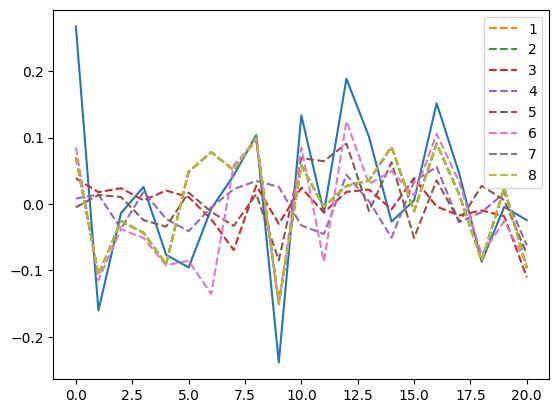

In [8]:
visualisation_effet_J(2)

In [ ]:
# visualisation_effet_J(1)